# Building a cloud based pasture prediction stack
An example for GEOM3001 by Peter Scarth

This session outlines a cloud-based workflow for building a total standing dry matter (TSDM) prediction model by calibrating field data to coincident Sentinel 2 imagery and then training a machine learning model to predict across the landscape.

It is a simplified version of the prediction and delivery method used by the startup company [Cibo Labs](https://www.cibolabs.com.au/pasturekey).

Being able to work using data sets on the cloud has a number of benefits.
 - Having the compute next to the imagery makes operations fast
 - Having access to fast data science platforms like [SageMaker](https://aws.amazon.com/sagemaker/) or [Google Colaboratory](https://research.google.com/colaboratory/) makes running experiments fast
 - Having access to scalable compute and free data makes the starting cost very low, and allows you to grow as your customer base grows

The [Cibo Labs](https://www.cibolabs.com.au/pasturekey) PastureKey process that we'll build a much simplified version of here is summarised in this diagram:

 ![Cibo Labs Pasture Key](https://www.cibolabs.com.au/hubfs/CiboLabs_December2021/Images/pasturekey-estimates.jpg)


## The first step is to import all the python libraries we'll need
If you're new to this, I'd recommend starting with [Miniconda](https://docs.conda.io/en/latest/miniconda.html) then installing the required packages in a new environment. I'd also recommend replacing conda with [mamba](https://github.com/mamba-org/mamba) to speed up the solving of python dependencies. Something like this should work:
```
conda create --name geom3001 python=3.9
conda activate geom3001 
conda install -c conda-forge mamba
mamba install -c conda-forge boto3 cramjam fastapi folium gcc gdal geopandas imageio jupyterlab matplotlib numexpr numpy pip plotly pystac-client rasterio rust uvicorn tensorflow
pip install titiler.application
```

In [1]:
# IMPORTS

from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
import folium
from osgeo import gdal
import rasterio
from imageio.v2 import imread
import tensorflow as tf
from pystac_client import Client


/home/pete/miniconda3/envs/geom3001/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.11.0-CAPI-1.17.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Organize Field Data

Field data is collected in the field using [Open Data Kit (ODK)](https://getodk.org/)
A form that allows the user to capture location, a photo and the Total Standing Dry Matter (TSDM) of pasture is given to producers.
Grass is cut in a know area using a quadrat, weighed when cut, then dried and weighed again.

![ODK App](https://www.cibolabs.com.au/hs-fs/hubfs/CiboLabs_December2021/Images/Living%20Laboratory.jpg)
### Load the data
Normally we'd pull the data directly from a PostGIS database, but here we will use a [FlatGeoBuf](https://flatgeobuf.org/) file hosted on a webserver. It's one of the few cloud optimised vector file formats. We prefix the location with [/vsicurl/](https://gdal.org/user/virtual_file_systems.html#vsicurl-http-https-ftp-files-random-access) to indicate to Geopandas that we want to read from a web endpoint. We could also use /vsis3/ to read directly from a AWS S3 bucket if the file was hosted there.

,transect_id,tsdm,points_center_lat,points_center_lng,sample_date,geometry
0,rqgsioklsvaukfyrtprndywruvjfhesx,1400,-25.673810,151.779993,2020-05-21,POINT (151.77999 -25.67381)
1,pmrrncgczplamiqrffexbsevkfjtcxzy,1335,-25.674966,151.773798,2020-05-21,POINT (151.77380 -25.67497)
2,ehtgxxdmqufrmjcpyvylhqmpfjjypaji,1845,-25.664339,151.771542,2020-05-22,POINT (151.77154 -25.66434)
3,kcfisqqjhujgxothionficnmnfaoofkf,4630,-25.680011,151.768055,2020-05-21,POINT (151.76806 -25.68001)
4,criebpvmarctjkawpdcqqidcxfhvmflr,2150,-25.663473,151.755347,2020-05-21,POINT (151.75535 -25.66347)


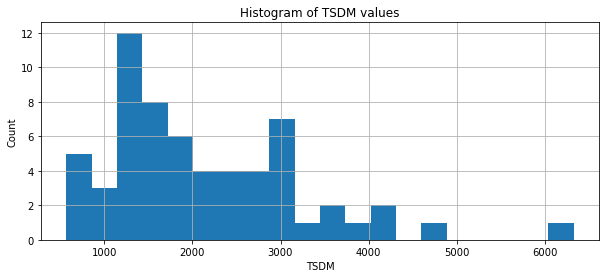

In [2]:
# Read the field data directly from the web without downloading the whole dataset
FIELD_DATA = '/vsicurl/https://github.com/petescarth/GEOM3001-7001/raw/main/odkFieldData.fgb'

# Load the field data into a geopandas dataframe
fieldData = gp.read_file(FIELD_DATA)

# Plot a histogram of the TSDM values to check the data range
fig, ax = plt.subplots(1,1,figsize=(10,4))
ax.hist(fieldData.tsdm, bins=20);
ax.set_ylabel('Count')
ax.set_xlabel('TSDM')
ax.set_title('Histogram of TSDM values')
ax.grid()

# Print the header to inspect the data
fieldData.head()



### Plot the data using Matplotlib on the Dataframe
[Geopandas](https://geopandas.org/) simplifies working with vector data in Python. Here we simply plot where the data is.

<AxesSubplot:>

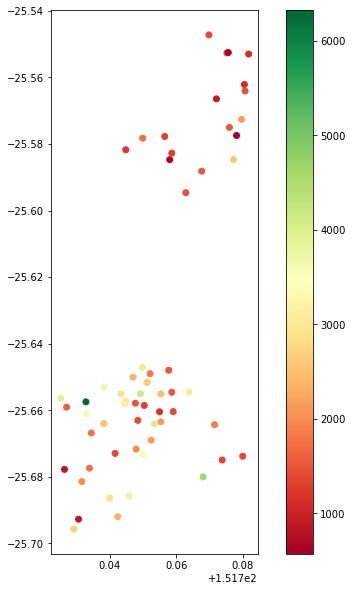

In [3]:
# Plot the dataframe using matplotlib
fieldData.plot(figsize=(10,10), aspect='equal', column='tsdm', cmap='RdYlGn', legend=True)

### Show the sites on a Slippy map
[Folium](https://python-visualization.github.io/folium/) uses [Leaflet](https://leafletjs.com/) (he leading open-source JavaScript library for mobile-friendly interactive maps) in the background to embed "Slippy" maps directly into notebooks.

In [4]:
# Plot the dataframe using folium - forst make the map with some defaults
map = folium.Map(
    location = [fieldData.points_center_lat.mean(),fieldData.points_center_lng.mean()],
     tiles = "OpenStreetMap", zoom_start = 12)

# Add the points to the map
folium.features.GeoJson(
    fieldData[['geometry','tsdm']].to_json(),
     tooltip=folium.GeoJsonTooltip(fields=['tsdm'])
     ).add_to(map)

# Show the map
map

## Select the best Sentinel 2 image from AWS
We want to find the most cloud free image close to the field data acquisition date. Pasture mass can change quickly in the growing season, or if grazed so we try to get imagery as close as possible to the date people were in the field. We could also use the cloud masks that come with the imagery if no cloud free scenes were available - it's just a slightly more complicated workflow.
To do this we:
 - filter from the 1,000,000's of images using the dates and bounds of the field data
 - select the tile with the lowest cloud to extract pixel values from to build a prediction model

### First create the time range and bounding box for the search:


In [5]:
bufferDate = 5 # days buffer around field work dates

# Work out the date range of the field data buffered by the specified number of days
earliestImageDate = (fieldData.sample_date.min() - timedelta(days=5)).strftime("%Y-%m-%d")
latestImageDate = (fieldData.sample_date.max() + timedelta(days=5)).strftime("%Y-%m-%d")

# Use thesxe dates to make a time range filter to use in the STAC query
timeRange = f"{earliestImageDate}/{latestImageDate}"

# Work out the bounding box of the field data to use in the STAC query
bbox = fieldData.total_bounds

# Print some info to the screen
print(f'Will search for imagery between {earliestImageDate} and {latestImageDate} using a bounding box of\n{bbox}')

Will search for imagery between 2020-05-14 and 2020-06-01 using a bounding box of
[151.7252935 -25.695717  151.7817585 -25.5472235]


#### Now search the STAC catalog
The [SpatioTemporal Asset Catalogs](https://stacspec.org) (STAC) specification is a common language to describe geospatial information, so it can more easily be worked with, indexed, and discovered.

A spatiotemporal asset is any file that represents information about the earth captured in a certain space and time.

Here we use PySTAC, a library for working with STAC, to find the Sentinel 2 tiles of interest in the [Sentinel-2 Cloud-Optimized GeoTIFFs](https://registry.opendata.aws/sentinel-2-l2a-cogs/) AWS Bucket 

In [6]:
# Search the Element84 STAC catalog
client = Client.open("https://earth-search.aws.element84.com/v0")
s2Search = client.search(
    collections=['sentinel-s2-l2a-cogs'],# or sentinel-s2-l2a
    datetime = timeRange,
    bbox=bbox
    )

# Show the results of the search
print(f"{s2Search.matched()} items found:\n{list(s2Search.items())}")


4 items found:
[<Item id=S2A_56JLS_20200529_0_L2A>, <Item id=S2B_56JLS_20200524_0_L2A>, <Item id=S2A_56JLS_20200519_0_L2A>, <Item id=S2B_56JLS_20200514_0_L2A>]


#### Show thumbnails and some information on the found Sentinel 2 Tiles
STAC results are returned as "Pages" of results, to avoid overwhelming the calling process with 1000's of results. The logic in the following code  is to:
 - look through each "page" of results,
 - look at the items in each page and download the JPEG thumbnail for each tile as a quick look
 - keep track of the item with the lowest cloud for further analysis



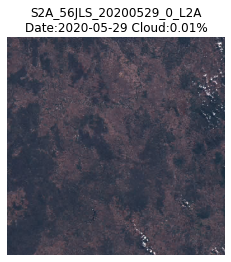

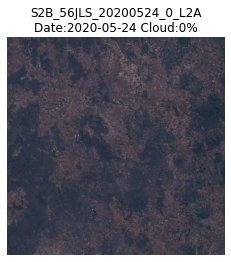

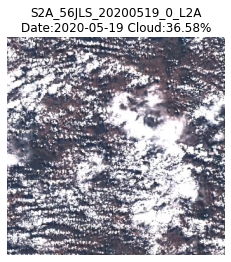

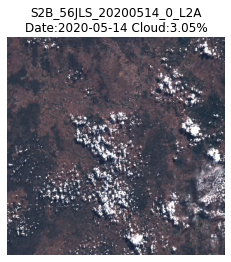

S2B_56JLS_20200524_0_L2A had the lowest cloud cover of 0%


In [7]:

# Variables to keep track of the Sentinel 2 asset, or item, with the lowest cloud cover
lowestCloudCover = 101
bestItem = None

# Loop for each page of results
for page in s2Search.item_collections():
    
    # Loop for each item in a page
    for item in page:
        
        # Get the amount of cloud from the item
        cloudAmount = item.properties['eo:cloud_cover']
        
        # If the cloud amount is lower than the lowest cloud cover so far, update the lowest cloud cover and the best item
        if cloudAmount < lowestCloudCover:
            lowestCloudCover = cloudAmount
            bestItem = item
        
        # Read the thumbnail of the Sentinel 2 asset, or item, and display it in a figure.
        # The thumbnail is a small image of the asset, and is used to show the user what the asset looks like
        # The imread libraryreads the image, which is a jpeg, as a numpy array
        thumbnail = imread(item.assets["thumbnail"].href);
        
        # Show the thumbnail - This sometimes times out on slow connections
        plt.imshow(thumbnail)
        
        # Add some metadata as the title
        dateString = item.get_datetime().strftime('%Y-%m-%d')
        plt.title(f"{item.id}{chr(10)}Date:{dateString} Cloud:{cloudAmount}%")
        plt.axis('off')
        
        # Notebook Trick: pause allows the notebook to render the plot
        plt.pause(1)

# Print some information on the best item
print(f"{bestItem.id} had the lowest cloud cover of {lowestCloudCover}%")

## Build a GDAL VRT file to access the Sentinel 2 data directly from AWS
There are a few ways of doing this, but the key is using GDAL's [virtual filesystem support](https://gdal.org/user/virtual_file_systems.html)

GDAL's [Virtual format (VRT)](https://gdal.org/drivers/raster/vrt.html) method allows the user to control things like:
 - resampling
 - mosaicing of tiles
 - output spatial resolution
 - output radiometric resolution and datatype
 - band ordering 
 - output projection
 - output data type
 - color tables
 - even band math on the fly

On AWS, the Sentinel bands are kept as separate assets called B01.tif, B02.tif etc. Because the Sentinel 2 bands have differing spatial resolutions this makes sense.

I like being able to access one Sentinel Tile as one file so I stack all the individual bands.

Here we use the "best" Sentinel 2 tile identified above and build a virtual representation of it using [gdalbuildvrt](https://gdal.org/programs/gdalbuildvrt.html)


In [8]:
# This can take a little while to run as GDAL needs to open each band before making the VRT

# Make a name for the VRT file
vrtName = bestItem.id+'.vrt'
print(f'Making: {vrtName}')


# List of the band names we're looking for to stack in the VRT
s2BandNames = ['B02','B03','B04','B05','B06','B07','B08','B11','B12']

# List to hold the individual band URLs
urlList = []

# Loop for each bandname
for band in s2BandNames:
    # Get the url for the band
    url = bestItem.assets[band].href
    print(url)
    # Add it to the list
    urlList.append('/vsicurl/' + url)


# First set some options for the VRT file
vrtOptions = gdal.BuildVRTOptions(resampleAlg='average', 
                                    separate=True,
                                    resolution='lowest',
                                    )
# Then make the VRT file using the list of URLs
vrtData = gdal.BuildVRT(vrtName, urlList, options = vrtOptions)
# Close the VRT file after we're done
vrtData = None





Making: S2B_56JLS_20200524_0_L2A.vrt
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_0_L2A/B02.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_0_L2A/B03.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_0_L2A/B04.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_0_L2A/B05.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_0_L2A/B06.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_0_L2A/B07.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_0_L2A/B08.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_0_L2A/B11.tif
https://sentinel-co

#### Test the VRT by calling gdalinfo
[gdalinfo](https://gdal.org/programs/gdalinfo.html) simply lists information about a raster data set.

In [9]:
!gdalinfo {vrtName}

Driver: VRT/Virtual Raster
Files: S2B_56JLS_20200524_0_L2A.vrt
       /vsicurl/https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_0_L2A/B02.tif
       /vsicurl/https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_0_L2A/B03.tif
       /vsicurl/https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_0_L2A/B04.tif
       /vsicurl/https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_0_L2A/B05.tif
       /vsicurl/https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_0_L2A/B06.tif
       /vsicurl/https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_0_L2A/B07.tif
       /vsicurl/https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/56/J/LS/2020/5/S2B_56JLS_20200524_0_L2A/B08.tif

### Access the Sentinel Data through the VRT
One of the cool things about [Cloud Optimized GeoTIFFs(https://www.cogeo.org/)] is that if you request a reduced spatial resolution it will read from the file overviews. This keeps data transfers low.

The cell below:
- Reads a three band reduced resolution (512 x 512 pixel) thumbnail of the Sentinel data using [rasterio](https://rasterio.readthedocs.io/en/latest/) on the VRT
- Stretches the data using a percentile stretch to make a pleasing visual image
- Displays the image in the notebook

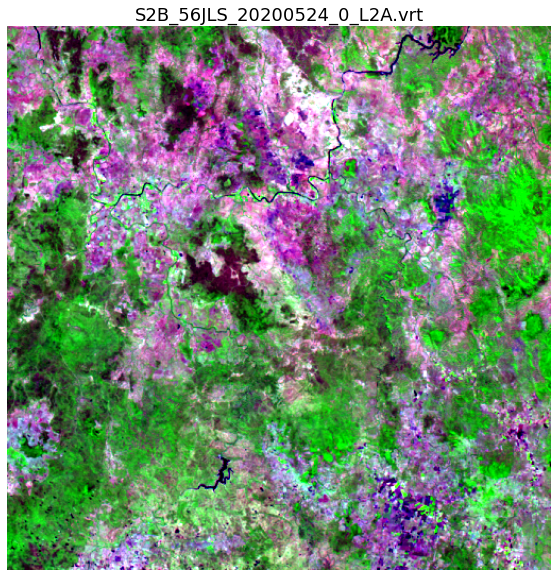

In [10]:
# List of the bands we want to read from the VRT
bandList = [8,7,3]

# Open the VRT using Rasterio
cloudRaster = rasterio.open(vrtName )

# Get only the data for the bands we want using a decimated read
falseColourThumbnail = cloudRaster.read(bandList,out_shape=(3, 512, 512))

# Change the ordering for matplotlib that wants the bands in the right order
falseColourThumbnail = np.rollaxis(falseColourThumbnail,0,3)

# Scale the data using a 2:98% stretch
scaleStats = np.percentile(falseColourThumbnail,[2,98],axis=(0,1))
falseColourThumbnail = (falseColourThumbnail - scaleStats[0]) / (scaleStats[1] - scaleStats[0])

# Clip the data to between 0 and 1
falseColourThumbnail = np.clip(falseColourThumbnail,0,1)

# Plot the data
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(falseColourThumbnail,aspect=1)

# Add the VRT Name to the title
ax.set_title(vrtName, fontsize=18)
ax.axis('off');


## Link the field TSDM data to the image
We want to link the field data to the reflectance of the coincident pixel so that we can build a prediction model for TSDM.

This is pretty easy using [Rasterio's sample module](https://rasterio.readthedocs.io/en/latest/api/rasterio.sample.html) once we have a list of coordinates in the same projection as the image data.


In [11]:
# Open the VRT using Rasterio
cloudRaster = rasterio.open(vrtName)

# Reproject the geometry to match the raster coordinate system
fieldProjectedGeometry = fieldData.geometry.to_crs(cloudRaster.crs)

# Build a list of coordinate pairs to pass to Rasterio's sample function
coordList = [(x,y) for x,y in zip(fieldProjectedGeometry.x , fieldProjectedGeometry.y)]

# Sample the raster (without downloading the entire raster) and add it to the dataframe as a list of values
fieldData['Sentinel2'] = [x for x in cloudRaster.sample(coordList)]

# Show what the fielddata dataframe looks like now
fieldData.head()


,transect_id,tsdm,points_center_lat,points_center_lng,sample_date,geometry,Sentinel2
0,rqgsioklsvaukfyrtprndywruvjfhesx,1400,-25.673810,151.779993,2020-05-21,POINT (151.77999 -25.67381),"[460, 641, 820, 1223, 1654, 1816, 2035, 2701, ..."
1,pmrrncgczplamiqrffexbsevkfjtcxzy,1335,-25.674966,151.773798,2020-05-21,POINT (151.77380 -25.67497),"[473, 636, 955, 1220, 1444, 1625, 1869, 3115, ..."
2,ehtgxxdmqufrmjcpyvylhqmpfjjypaji,1845,-25.664339,151.771542,2020-05-22,POINT (151.77154 -25.66434),"[271, 418, 485, 864, 1461, 1672, 1817, 1903, 1..."
3,kcfisqqjhujgxothionficnmnfaoofkf,4630,-25.680011,151.768055,2020-05-21,POINT (151.76806 -25.68001),"[462, 648, 1008, 1215, 1508, 1665, 1987, 2563,..."
4,criebpvmarctjkawpdcqqidcxfhvmflr,2150,-25.663473,151.755347,2020-05-21,POINT (151.75535 -25.66347),"[403, 580, 751, 1087, 1446, 1599, 1793, 2614, ..."


## Build a Tensorflow Multi Layer Perceptron (MLP) model to predict Total Standing Dry Matter
We define and train a very simple [MLP Model](https://en.wikipedia.org/wiki/Multilayer_perceptron) in [Tensorflow Keras](https://keras.io/). This is just one of many machine learning models that could be appropriate for this task, and I introduce it here as an alternative to the very popular (in remote sensing) [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) model. We use Tensorflow because it trains fast on a GPU, the Keras API is reasonably accessible, and it has great hardware support running on x86 and ARM CPUs, TPUs, and even in the [browser](https://www.tensorflow.org/js).

 - We scale the field and image data into the 0-1 range
 - Use the [Huber loss](https://en.wikipedia.org/wiki/Huber_loss) function due to it's robustness to outliers from  dodgy field data
 - Use the [Adam](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam) optimiser
 - Train it for 600 iterations, using 33% of the field data for validation
 - Plot the training and validation losses

The model architecture we're using here is represented in the diagram below.

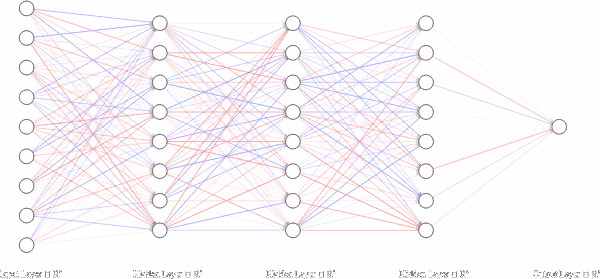


2022-08-08 06:10:47.182766: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


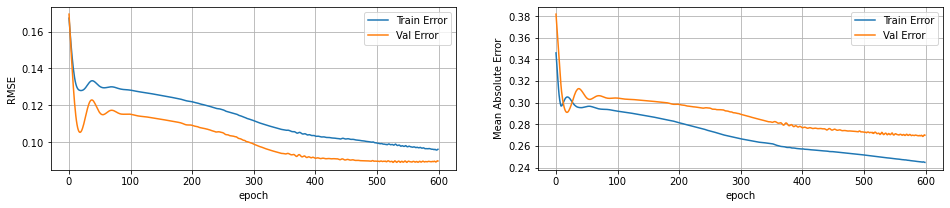

In [12]:
# Shuffle the data so remove spatial and temporal correlations
fieldData.sample()

# Extract X and y data from the dataframe into numpy arrays
# X is the Sentinel2 data, y is the field TSDM data
X = np.array(fieldData['Sentinel2'].to_list(),dtype=np.float32)
y = np.array(fieldData['tsdm'],dtype=np.float32)

# Scale the data from 0 to 1
X = X / 10000 # Scale to reflectance
y = y / 10000 # Scale to t/Ha/10 

# Build a simple 3 layer neural network using the KERAS library
tsdmMLP = tf.keras.Sequential([
tf.keras.layers.Dense(8, activation='relu', input_shape=[X.shape[1]]),
tf.keras.layers.Dense(8, activation='relu'),
tf.keras.layers.Dense(8, activation='relu',),
tf.keras.layers.Dense(1)
])

# Compile the model using the huber loss function and the Adam optimizer
tsdmMLP.compile(loss=tf.keras.losses.Huber(delta = 0.05),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=['mean_absolute_error', 'mean_squared_error'])

# Fit the model to the data using 600 training epochs and a validation split of 33%
history = tsdmMLP.fit(X,y, epochs = 600,
                    validation_split = 0.33,
                    shuffle = True,
                    batch_size = 8192,
                    verbose=0)

###############################################################################################
# Make a plot of the training run
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,3))

# Plot the mean squared error loss function
ax1.plot(history.epoch, np.sqrt(history.history['mean_squared_error']),label='Train Error')
ax1.plot(history.epoch, np.sqrt(history.history['val_mean_squared_error']),label = 'Val Error')
ax1.set_xlabel('epoch')
ax1.set_ylabel('RMSE')
ax1.grid()
ax1.legend()

# Plot the mean absolute error loss function
ax2.plot(history.epoch, np.sqrt(history.history['mean_absolute_error']),label='Train Error')
ax2.plot(history.epoch, np.sqrt(history.history['val_mean_absolute_error']),label = 'Val Error')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Mean Absolute Error')
ax2.grid()
ax2.legend()


## Use the Tensorflow model to predict on the full data set
In this example we're accessing the image from the cloud and writing locally, but this could happen entirely on the cloud.

First we define a function that takes the Sentinel 2 bands and returns a predicted TSDM value.

Then we apply that model block by block to the Sentinel 2 data read over the VRT. Because we are processing the full image this takes a while. In operational use, you would typically process only your region of interest at the desired spatial resolution to save compute.

Rather than reading the entire image, we use blocks of imagery called [windows](https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html) to minimise memory use, and can be used to parallelize the process if more CPU's are available.

We are careful to compress the tiff file, write it in tiles, and generate overviews (or pyramid layers) so that processes using it can efficiently access it on the cloud as well. This is not a fully [Cloud Optimized GeoTiff](https://www.cogeo.org/) but in practice it is quite close.

In [14]:
# Make a filename for the prediction using the VRT name
tsdmImageName = vrtName.replace('.vrt','_tsdm.tif')
print(f'Making: {tsdmImageName}')

###############################################################################################
# The prediction function that takes a numpy array of data and a tensorflow model object
# Returns a numpy array of TSDM predictions
def predictTsdm(nbar, tsdmMLP):
    
    # Get the shape of the input sentinel 2 array
    inshape = nbar.shape
    
    # Flatten the array to Bands x Pixels and scale the reflectance like when we trained the model
    nbar = np.reshape(nbar,(inshape[0],-1)) / 10000.0
    
    # Run the prediction on the tensorflow model. Increase the batch size to 512 x 512 to speed up the prediction
    tsdm = tsdmMLP.predict(nbar.T,batch_size=262144, verbose =0)
    
    # Round and clip the predictions from 1 to 10000 kg/Ha
    tsdm = np.clip(np.round(tsdm * 10000),1,10000)

    # Handle nodata in the input by making output nodata values 0
    tsdm[nbar[0] ==0 ] = 0
    tsdm[nbar[0] > 1] = 0
    
    # Reshape the output back to the input shape and return it
    return np.reshape(tsdm,(1,inshape[1],inshape[2])).astype(np.uint16)

###############################################################################################
# Apply the prediction function to the raster
# First open the raster using Rasterio
with rasterio.open(vrtName) as src:
    
    # Set the output file metadata from the input raster
    kwargs = src.meta
    # Set the output driver to GTiff
    kwargs['driver']='GTIFF'
    # Set the number of bands to 1
    kwargs['count']=1
    # Set the output nodata value to 0
    kwargs['nodata']=0
    # Set the output datatype to uint16
    kwargs['dtype']='uint16'
    
    # Use the rasterio windowed tiling iterator
    tiles = src.block_windows(0)
    
    # Open the output file for writing with compression and tiling
    with rasterio.open(tsdmImageName, 'w', **kwargs,
                         compress="DEFLATE",
                         tiled=True, 
                         blockxsize=256, 
                         blockysize=256) as dst:
        
        # Iterate through the tiles
        for idx, window in tiles:
            # Read the data from the input raster
            srcData = src.read(window=window).astype(np.float32)
            
            # Run the prediction function defined above on the data
            dstData = predictTsdm(srcData,tsdmMLP)
            
            # Write the data to the output raster
            dst.write(dstData, window=window)
        
        # Before closing the file, build overviews
        dst.build_overviews([2, 4, 8, 16, 32, 64, 128, 256])



Making: S2B_56JLS_20200524_0_L2A_tsdm.tif


### Plot the TSDM image
Now we've run the prediction across the entire image, we can view it next to the original data to check the prediction.

We use the same Rasterio based image reading and the stretch introduced previously to view the two images side by side.


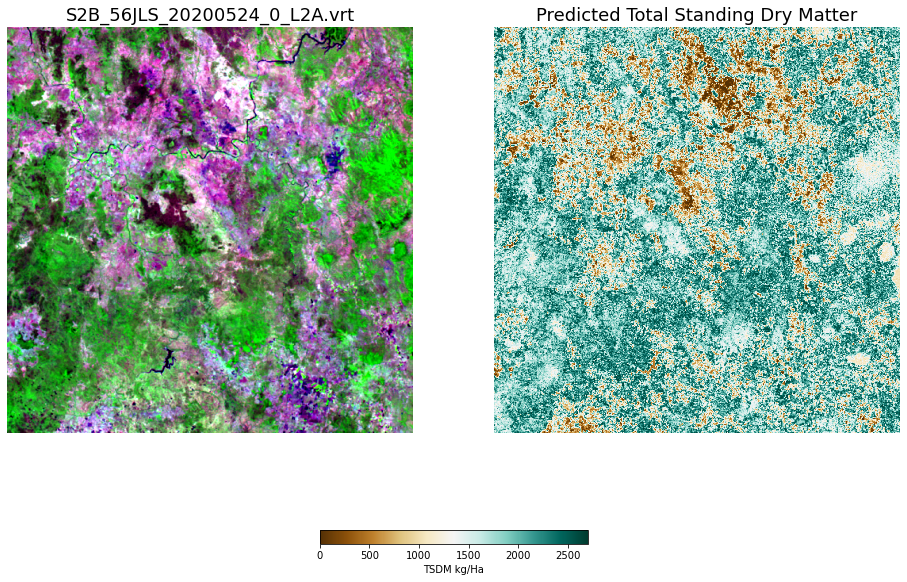

In [15]:
# Make a filename for the prediction
tsdmImageName = vrtName.replace('.vrt','_tsdm.tif')

###############################################################################################
# Load the Sentinel 2 data into an array ready to plot
cloudRaster = rasterio.open(vrtName )

# Get the data for the bands we want using a decimated read
falseColourThumbnail = cloudRaster.read([8,7,3],out_shape=(3, 512, 512))

# Change the band ordering for matplotlib
falseColourThumbnail = np.rollaxis(falseColourThumbnail,0,3)

# Scale the data using a 2:98% stretch
scaleStats = np.percentile(falseColourThumbnail,[2,98],axis=(0,1))
falseColourThumbnail = (falseColourThumbnail - scaleStats[0]) / (scaleStats[1] - scaleStats[0])

# Clip the data from 0 to 1
falseColourThumbnail = np.clip(falseColourThumbnail,0,1)

###############################################################################################
# Load the TSDM raster into an array ready to plot
tsdmRaster = rasterio.open(tsdmImageName)

# Get the data for the bands using a decimated read
tsdmThumbnail = tsdmRaster.read(1,out_shape=(1, 512, 512))

# Scale the data using a 2:98% stretch
scaleStats = np.percentile(tsdmThumbnail,[2,98],axis=(0,1))
tsdmThumbnail = (tsdmThumbnail - scaleStats[0]) / (scaleStats[1] - scaleStats[0])

# Clip the data to between 0 and 1 then scale by the maximum TSDM
tsdmThumbnail = np.clip(tsdmThumbnail,0,1) * scaleStats[1]

###############################################################################################
# Plot the image and prediction side by side with a legend
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,12))

# Sentinel 2 Image
ax1.imshow(falseColourThumbnail,aspect=1)
ax1.set_title(vrtName, fontsize=18)
ax1.axis('off');

# TSDM prediction
im = ax2.imshow(tsdmThumbnail,aspect=1,cmap='BrBG')
ax2.set_title('Predicted Total Standing Dry Matter', fontsize=18)
ax2.axis('off');

# Legend
cbar = fig.colorbar(im, ax=[ax1,ax2],location='bottom', shrink=0.3)
cbar.set_label('TSDM kg/Ha')



## Make the result available as a web service
This uses the Developmentseed [TiTiler] (https://developmentseed.org/titiler/) library.

_"A modern dynamic tile server built on top of FastAPI and Rasterio/GDAL"_

It is a cloud-first image tiler that takes an image (or a mosaic of images) and serves them up to users on the web via a [Swagger]() api. It can be hosted on a regular server, and also as a serverless [AWS Lambda function](https://aws.amazon.com/lambda/) or as a Docker container on an [Elastic Container Service](https://docs.aws.amazon.com/AmazonECS/latest/developerguide/Welcome.html). 

It is also able to apply stretches, color tables, calculate statistics and compute band math functions on the fly.

For this to work, the image must be hosted on a web server, preferably in cloud optimized format. 

For this demonstration I'll run this using a local webserver, but in production the image would be on a cloud web server or in a cloud bucket (like S3 etc).





In [39]:
# Run TiTiler to serve a web map
!uvicorn titiler.application.main:app

# The API documentation is then available at http://127.0.0.1:8000/docs
# A COG viewer is available at http://127.0.0.1:8000/cog/viewer

# Start a local web server in the background to serve the images
# For me in VS Code this means the image is at http://127.0.0.1:5500/S2B_56JLS_20200524_0_L2A_tsdm.tif
# Paste this URL into the COG Viewer to make a slippy map.


INFO:     Started server process [11928]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
INFO:     127.0.0.1:59326 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:59326 - "GET /docs HTTP/1.1" 200 OK
^C
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [11928]


## Summary
This cloud workflow example is only touching the surface of what is possible, but the take home message is that being able to understand the opportunities, and/or be able to work programmatically in cloud based systems, is a very useful (and employable) skill to acquire.

Processing massive amounts of satellite data is now available to anyone, through frameworks like the Google Earth Engine, Open Data Cube, Sentinel Hub and Microsoft Earth. The process outlined in this notebook could be easily undertaken in any of these. The reasons you might want to build your own cloud processing workflow could be to reduce costs, utilize a technology stack not available elsewhere, utilize data formats not available elsewhere, integrate datasets not available natively on a chosen platform or to just have greater certainty around platform changes or deprecations.

For Cibo Labs, the critical cloud technologies used are based on a more traditional HPC computing stack rather then tools like docker, kubernetes and AWS Lambda (although we also leverage these in production where appropriate). In particular we make heavy use of:
 - AWS Batch to run Gravitron (ARM) instances using spot pricing to minimize costs when processing machine learning models on thousands of Sentinel 2 tiles or running zonal statistics across millions of polygons, currently costing around USD4600/month.
 - Aurora Serverless PostGIS databases which give us a fully scalable spatial database to store, aggregate, cluster and deliver billions of precomputed statistics against various spatial aggregations (like Cadastre, NRM regions, Postcodes etc) currently costing around USD 1600/month.

